In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [2]:
df_all = pd.read_csv('C:/Temp/all_features.csv')

In [3]:
#Columns are:
# 'defining_polynomial'
# 'class_number'
# 'discriminant'
# 'signature_r1', 'signature_r2'
# 'unit_group_rank'
# 'number_roots_unity'
# 'regulator'
# 'zeta_coeff'
# '_2', '_3', '_4', '_5', ...

print(df_all.columns.tolist())

['defining_polynomial', 'class_number', 'discriminant', 'signature_r1', 'signature_r2', 'unit_group_rank', 'number_roots_unity', 'regulator', 'zeta_coeff', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14', '_15', '_16', '_17', '_18', '_19', '_20', '_21', '_22', '_23', '_24', '_25', '_26', '_27', '_28', '_29', '_30', '_31', '_32', '_33', '_34', '_35', '_36', '_37', '_38', '_39', '_40', '_41', '_42', '_43', '_44', '_45', '_46', '_47', '_48', '_49', '_50', '_51', '_52', '_53', '_54', '_55', '_56', '_57', '_58', '_59', '_60', '_61', '_62', '_63', '_64', '_65', '_66', '_67', '_68', '_69', '_70', '_71', '_72', '_73', '_74', '_75', '_76', '_77', '_78', '_79', '_80', '_81', '_82', '_83', '_84', '_85', '_86', '_87', '_88', '_89', '_90', '_91', '_92', '_93', '_94', '_95', '_96', '_97', '_98', '_99', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_120'

In [4]:
df_train, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all.iloc[:, 1])

# column to predict is 'class_number' (1st column)
# column indexing is zero-based
y_train = df_train.iloc[:,1]
y_test = df_test.iloc[:,1]

# matrix of explanatory variables includes
# column 2 to 8
X_train = df_train.iloc[:,2:1001] #[:,2:9]
X_test = df_test.iloc[:,2:1001]

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train, y_train)
#LR.predict(df_test.iloc[:,2:9])

score = LR.score(X_test, y_test)
print(score)


0.9073678664522212


In [14]:
df_plot = df_all.sample(1000)

dr1 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == 1]['discriminant'],
    y=df_plot[df_plot['class_number'] == 1]['regulator'],
    z=df_plot[df_plot['class_number'] == 1]['zeta_coeff'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(255,0,0)',
                  line=dict(width=1)),
    name ='Discriminant-Regulator-_1'
)
dr2 = go.Scatter3d(
    x=df_plot[df_plot['class_number'] == 2]['discriminant'],
    y=df_plot[df_plot['class_number'] == 2]['regulator'],
    z=df_plot[df_plot['class_number'] == 2]['zeta_coeff'],
    mode='markers',
    marker = dict(size=3,
                  color='rgb(0,255,0)',
                  line=dict(width=1)),
    name ='Discriminant-Regulator-_2'
)

data = [dr1, dr2]
layout = go.Layout(
    title='PH-scale',
    scene = dict(
        xaxis = dict(title='blue'),
        yaxis = dict(title='red'),
        zaxis = dict(title='green'),)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='ph-scale')

1    525
2    475
Name: class_number, dtype: int64


In [ ]:
#https://www.kaggle.com/robjan/binary-classification-with-visualization
#https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas



    defining_polynomial  class_number  number_roots_unity  _2  _3
400       x^2 - x - 634             1                   2   2   0
401       x^2 - x - 637             1                   2   0   0
402       x^2 - x - 642             1                   2   2   2
403           x^2 - 643             1                   2   1   2
404       x^2 - x - 643             1                   2   0   0
405       x^2 - x - 644             1                   2   2   1
406           x^2 - 647             1                   2   1   0
407       x^2 - x - 648             1                   2   2   2
408       x^2 - x - 652             1                   2   2   0
409       x^2 - x - 654             1                   2   2   2
410       x^2 - x - 655             1                   2   0   0


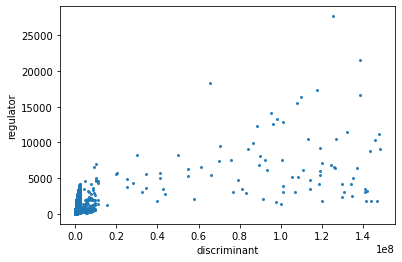

In [10]:
print(df_all.loc[400:410, ['defining_polynomial', 'class_number', 'number_roots_unity', '_2', '_3']])
df_plot = df_all.iloc[0:1000]
#df_plot = df_all
x = df_plot['discriminant'].to_numpy()
y = df_plot['regulator'].to_numpy()
colors = df_all['class_number']
color_map = {1:'red', 2:'blue'}

f = plt.figure()
#plt.scatter(x, y, s=4, alpha=0.9, c=colors.map(color_map))
plt.scatter(x, y, s=4, alpha=0.9)
#plt.title("class 1 (red) and class 2 (blue) for x^2 + bx + c")
plt.xlabel("discriminant")
plt.ylabel("regulator")
plt.show()